<a href="https://colab.research.google.com/github/IC-UFAL-IADD/IADD/blob/codebasics/%5B2022%5D_Lightning_MONAI_PNG_classification2D.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

### References:
https://pycad.co/preprocessing-3d-volumes-for-tumor-segmentation-using-monai-and-pytorch/

https://towardsdatascience.com/pytorch-layer-dimensions-what-sizes-should-they-be-and-why-4265a41e01fd



In [ ]:
!pip install -qU "monai[ignite, nibabel, torchvision, tqdm]==0.6.0"
!pip install -q "monai-weekly[itk, pillow]"
!pip install pytorch-lightning
!pip install torchmetrics

In [ ]:
import os
import shutil
import tempfile
import torch
import torch.nn as nn
import torch.nn.functional as F

import pytorch_lightning as pl
print(pl.__version__)
from pytorch_lightning.core.lightning import LightningModule

import torchmetrics
from torchmetrics import F1
from torchmetrics import MetricCollection, Accuracy, Precision, Recall, F1, AUROC

from PIL import Image, ImageFont, ImageDraw
import torch.utils.data as data
import torchvision
from torchvision import transforms 
import torchvision.models as models
import nibabel as nib
import numpy as np
import matplotlib.pyplot as plt
from typing import Optional, Any, Mapping, Hashable

import monai
from monai.config import print_config
from monai.config import KeysCollection
from monai.data import decollate_batch
from monai.networks.nets import DenseNet121
from monai.metrics import ConfusionMatrixMetric, ROCAUCMetric
from monai.data import Dataset, ArrayDataset, create_test_image_3d, DataLoader
from monai.transforms import (
    Transform,
    Activations,
    AsDiscrete,
    AddChannel,
    CenterSpatialCrop,
    Compose,
    CropForeground,
    EnsureType,
    LoadImage,
    NormalizeIntensity,
    RandRotate,
    RandFlip,
    RandZoom,
    Resize,
    ScaleIntensity,
    ToTensor,
    Rotate
)
print_config()

1.5.8
MONAI version: 0.9.dev2203
Numpy version: 1.19.5
Pytorch version: 1.10.0+cu111
MONAI flags: HAS_EXT = False, USE_COMPILED = False
MONAI rev id: 7b99fe4129b2804dbb58a4055314df4493cb488d
MONAI __file__: /usr/local/lib/python3.7/dist-packages/monai/__init__.py

Optional dependencies:
Pytorch Ignite version: 0.4.5
Nibabel version: 3.0.2
scikit-image version: 0.18.3
Pillow version: 7.1.2
Tensorboard version: 2.7.0
gdown version: 3.6.4
TorchVision version: 0.11.1+cu111
tqdm version: 4.62.3
lmdb version: 0.99
psutil version: 5.4.8
pandas version: 1.1.5
einops version: NOT INSTALLED or UNKNOWN VERSION.
transformers version: NOT INSTALLED or UNKNOWN VERSION.
mlflow version: NOT INSTALLED or UNKNOWN VERSION.

For details about installing the optional dependencies, please visit:
    https://docs.monai.io/en/latest/installation.html#installing-the-recommended-dependencies



In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
data_dir = "/content/drive/MyDrive/DataSets/covid_Test/"
#Obtem os nomes dos diretorios na Pasta (data_dir)
class_names = sorted(x for x in os.listdir(data_dir)
                     if os.path.isdir(os.path.join(data_dir, x)))
#Obtem a quantidade de imagens em cada pasta
num_class = len(class_names)
print("N. de Classes..:", num_class)

image_files = [
    [
        os.path.join(data_dir, class_names[i], x)
        for x in os.listdir(os.path.join(data_dir, class_names[i]))
    ]
    for i in range(num_class)
]

#Imagens por Classe
num_each = [len(image_files[i]) for i in range(num_class)]
image_files_list = []
image_class = []

#Total de Imagens
for i in range(num_class):
    image_files_list.extend(image_files[i])
    image_class.extend([i] * num_each[i])
num_total = len(image_class)

print(f"Total image count: {num_total}")
print(f"Label names: {class_names}")
print(f"Label counts: {num_each}")

N. de Classes..: 2
Total image count: 677
Label names: ['COVID', 'normal']
Label counts: [310, 367]


## Preparo da lista de imagens para Treinamento, Validação e Teste

In [ ]:
#Define o split do DataSet
val_frac = 0.2
test_frac = 0.2
length = len(image_files_list)
indices = np.arange(length)
np.random.shuffle(indices)

test_split = int(test_frac * length)
val_split = int(val_frac * length) + test_split
test_indices = indices[:test_split]
val_indices = indices[test_split:val_split]
train_indices = indices[val_split:]

#Lembrar que Y é o Label
train_x = [image_files_list[i] for i in train_indices]
train_y = [image_class[i] for i in train_indices]
val_x = [image_files_list[i] for i in val_indices]
val_y = [image_class[i] for i in val_indices]
test_x = [image_files_list[i] for i in test_indices]
test_y = [image_class[i] for i in test_indices]

print(
    f"Training count: {len(train_x)}, Validation count: "
    f"{len(val_x)}, Test count: {len(test_x)}")

Training count: 407, Validation count: 135, Test count: 135


## Adotamos MONAI para Processamento e Dataloader do DataSet

<class 'torch.Tensor'> torch.Size([1, 64, 64])


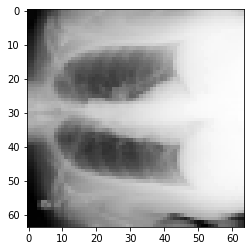

In [ ]:
train_transforms = Compose(
    [
        LoadImage(image_only=True),
        AddChannel(),
        NormalizeIntensity(),
        ScaleIntensity(),
        RandRotate(range_x=np.pi / 12, prob=0.5, keep_size=True),
        RandFlip(spatial_axis=0, prob=0.5),
        RandZoom(min_zoom=0.9, max_zoom=1.1, prob=0.5),
        Resize(spatial_size=[64, 64], size_mode='all'),
        EnsureType(),
        ToTensor(),
    ]
)

img = train_transforms(train_x[0])
print(type(img), img.shape)
plt.imshow(transforms.ToPILImage()(img), cmap='gray')

In [ ]:
val_transforms = Compose(
    [
        LoadImage(image_only=True),
        AddChannel(),
        NormalizeIntensity(),
        ScaleIntensity(),
        Resize(spatial_size=[64, 64], size_mode='all'),
        EnsureType(),
        ToTensor(),
    ]
)

In [ ]:
y_pred_trans = Compose([EnsureType(), Activations(softmax=True)])
y_trans = Compose([EnsureType(), AsDiscrete(to_onehot=num_class)])

## Classe MONAI para Manipular o DataSet

In [ ]:
class COVID_Dataset(monai.data.Dataset):
    def __init__(self, image_files, labels, transforms):
        self.image_files = image_files
        self.labels = labels
        self.transforms = transforms

    def __len__(self):
        return len(self.image_files)

    def __getitem__(self, index):
        return self.transforms(self.image_files[index]), self.labels[index]

In [ ]:
#Carrega imagens de Treino
train_ds = COVID_Dataset(train_x, train_y, train_transforms)
train_loader = monai.data.DataLoader(train_ds, batch_size=32, num_workers=2 )

In [ ]:
#Carrega imagens de Validação
val_ds = COVID_Dataset(val_x, val_y, val_transforms)
val_loader = monai.data.DataLoader(
    val_ds, batch_size=32, num_workers=2)

#Carrega imagens de Teste
test_ds = COVID_Dataset(test_x, test_y, val_transforms)
test_loader = monai.data.DataLoader(
    test_ds, batch_size=32, num_workers=2)

## Construção do Modelo de Deep Learning usando Pytorch

In [ ]:
class IADDModel(pl.LightningModule):
  def __init__(self):
    super().__init__()
    #in_channels[1(grayscale), 3(RGB)], out_channels(nº de Kernels)
    self.conv1 = nn.Conv2d(1, 96, kernel_size=11, stride=1, padding=1)
    self.act1 = nn.ReLU()
    self.pool1 = nn.MaxPool2d(2)

    self.conv2 = nn.Conv2d(96, 256, kernel_size=5, stride=1, padding=1)
    self.act2 = nn.ReLU()
    self.pool2 = nn.MaxPool2d(2)


    self.conv3 = nn.Conv2d(256, 384, kernel_size=3, stride=1, padding=1)
    self.act3 = nn.ReLU()
    
    self.conv4 = nn.Conv2d(384, 385, kernel_size=3, stride=1, padding=1)
    self.act4 = nn.ReLU()

    self.conv5 = nn.Conv2d(385, 256, kernel_size=5, stride=1, padding=1)
    self.act5 = nn.ReLU()
    self.pool5 = nn.MaxPool2d(2)

    
    #in_features: tamanho da imagem após os "Pooling"incluido o nº de kernels, out_features: nº de hidden layers
    #Dica: pegue o input da FC1 com a msg de erro do Pytorch
    self.fc1 = nn.Linear(6400, 4096)
    self.act6 = nn.ReLU()

    self.fc2 = nn.Linear(4096, 4096)
    self.act7 = nn.ReLU()

    self.fc3 = nn.Linear(4096, num_class)
    self.softmax = nn.Softmax(dim=1)

    metrics = MetricCollection([AUROC(num_classes=num_class, pos_label=num_class), Accuracy(num_classes=num_class), Precision(num_classes=num_class, average='macro'), Recall(num_classes=num_class, average='macro'), F1(num_classes=num_class, average='macro')])
    self.train_metrics = metrics.clone(prefix='train_')
    self.valid_metrics = metrics.clone(prefix='val_')
    self.test_metrics = metrics.clone(prefix='test_')

    

  def forward(self, x):
    out = self.conv1(x)
    out = self.act1(out)
    out = self.pool1(out)

    out = self.conv2(out)
    out = self.act2(out)
    out = self.pool2(out)

    out = self.conv3(out)
    out = self.act3(out)
    
    out = self.conv4(out)
    out = self.act4(out)
    
    out = self.conv5(out)
    out = self.act5(out)
    out = self.pool5(out)
    
    out = torch.flatten(out, 1)

    out = self.fc1(out)
    out = self.act6(out)

    out = self.fc2(out)
    out = self.act7(out)

    out = self.fc3(out)
    out = self.softmax(out)
    return out

  def configure_optimizers(self):
    optimizer = torch.optim.Adam(self.parameters(), lr=1e-5)
    return optimizer
  
  def training_step(self, batch, batch_idx):
    #x=imagem; y=label
    x, y = batch
    y_hat = self(x)
    
    #Calcula o erro
    loss = F.cross_entropy(y_hat, y)

    #metricas e Plot
    output = self.train_metrics(y_hat, y)
    self.log_dict(output)
    return loss

  def validation_step(self, batch, batch_idx):
    x, y = batch
    y_hat = self(x)
    val_loss = F.cross_entropy(y_hat, y)

    output = self.valid_metrics(y_hat, y)
    self.log_dict(output)

    return val_loss

  def test_step(self, batch, batch_idx):
    x, y = batch
    y_hat = self(x)
    loss = F.cross_entropy(y_hat, y)
    
    output = self.test_metrics(y_hat, y)
    self.log_dict(output)
    return loss



## Treinamento do Modelo

In [ ]:
model = IADDModel()

trainer = pl.Trainer(gpus=1, max_epochs=4, progress_bar_refresh_rate=1)

# Train the model ⚡
trainer.fit(model, train_loader, val_loader)


Metric `AUROC` will save all targets and predictions in buffer. For large datasets this may lead to large memory footprint.
The `F1` was deprecated since v0.7 in favor of `torchmetrics.classification.f_beta.F1Score`. It will be removed in v0.8.
Setting `Trainer(progress_bar_refresh_rate=1)` is deprecated in v1.5 and will be removed in v1.7. Please pass `pytorch_lightning.callbacks.progress.TQDMProgressBar` with `refresh_rate` directly to the Trainer's `callbacks` argument instead. Or, to disable the progress bar pass `enable_progress_bar = False` to the Trainer.
GPU available: True, used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
Missing logger folder: /content/lightning_logs

   | Name          | Type             | Params
----------------------------------------------------
0  | conv1         | Conv2d           | 11.7 K
1  | act1          | ReLU             | 0     
2  | pool1         | MaxPool2d        

Validation sanity check: 0it [00:00, ?it/s]

Argument `pos_label` should be `None` when running multiclass precision recall curve. Got 2
The number of training samples (13) is smaller than the logging interval Trainer(log_every_n_steps=50). Set a lower value for log_every_n_steps if you want to see logs for the training epoch.


Training: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

In [ ]:
trainer.test(dataloaders=test_loader)

`.test(ckpt_path=None)` was called without a model. The best model of the previous `fit` call will be used. You can pass `test(ckpt_path='best')` to use and best model checkpoint and avoid this warning or `ckpt_path=trainer.checkpoint_callback.last_model_path` to use the last model.
Restoring states from the checkpoint path at /content/lightning_logs/version_0/checkpoints/epoch=3-step=51.ckpt
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
Loaded model weights from checkpoint at /content/lightning_logs/version_0/checkpoints/epoch=3-step=51.ckpt


Testing: 0it [00:00, ?it/s]

Argument `pos_label` should be `None` when running multiclass precision recall curve. Got 2


--------------------------------------------------------------------------------
DATALOADER:0 TEST RESULTS
{'test_AUROC': 0.5377696752548218,
 'test_Accuracy': 0.5703703761100769,
 'test_F1': 0.3630417287349701,
 'test_Precision': 0.28518518805503845,
 'test_Recall': 0.5}
--------------------------------------------------------------------------------


[{'test_AUROC': 0.5377696752548218,
  'test_Accuracy': 0.5703703761100769,
  'test_F1': 0.3630417287349701,
  'test_Precision': 0.28518518805503845,
  'test_Recall': 0.5}]

## Transfer Learning usando DenseNET121

* 1 7x7 Convolution
* 58 3x3 Convolution
* 61 1x1 Convolution
* 4 AvgPool
* 1 Fully Connected Layer

In [ ]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

net = DenseNet121(spatial_dims=2, in_channels=1,
                    out_channels=num_class).to(device)

loss_function = torch.nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), 1e-5)
val_interval = 1
auc_metric = ROCAUCMetric()

In [ ]:
epoch_num = 4
best_metric = -1
best_metric_epoch = -1
epoch_loss_values = list()
metric_values = list()
act = y_pred_trans
to_onehot = y_trans

for epoch in range(epoch_num):
    print("-" * 10)
    print(f"epoch {epoch + 1}/{epoch_num}")

    epoch_loss = 0
    step = 1

    steps_per_epoch = len(train_ds) // train_loader.batch_size
    
    '''
    A função train() coloca a rede no modo treino e habilita os modulos 
    para realizar normalização e dropout.
    '''
    net.train()
    for batch_data in train_loader:

        # move os dados para a GPU
        inputs, labels = batch_data[0].to(device), batch_data[1].to(device)

        # Prepara o gradiente para os passos do back propagation
        optimizer.zero_grad()
        
        # Passa o 1o batch de dados pela rede
        outputs = net(inputs)
        
        # Calcula o Loss
        loss = loss_function(outputs, labels)
        
        # Calcula o gradient
        loss.backward()
        
        # Informa o optimizer para atualizar os pesos conforme o gadiente e a sua estratégia de otimização
        optimizer.step()

        epoch_loss += loss.item()
        print(f"{step}/{len(train_ds) // train_loader.batch_size + 1}, training_loss: {loss.item():.4f}")
        step += 1

    epoch_loss /= step
    epoch_loss_values.append(epoch_loss)
    print(f"epoch {epoch + 1} average loss: {epoch_loss:.4f}")

    # Após cada época é executada a metrica de avaliação e se existe melhor salva o modelo
    
    # Aciona o processo de Validação do Modelo
    net.eval()

    # Na validação desligamos o calculo gradiente 
    with torch.no_grad():
        # Criamos a lista que irá concatenar os resultados da Validação
        preds = list()
        labels = list()

        # Iteramos em cada batch de imagem e passamos ele na rede em mode de avaliação
        for val_data in val_loader:
            val_images, val_labels = val_data[0].to(device), val_data[1].to(device)

            # excuta a rede
            val_pred = net(val_images)

            preds.append(val_pred)
            labels.append(val_labels)

        # Concatena as predições e os labels 
        y_pred = torch.cat(preds)
        y = torch.cat(labels)

        # we are using the area under the receiver operating characteristic (ROC) curve to determine
        # whether this epoch has improved the best performance of the network so far, in which case
        # we save the network in this state
        y_onehot = [to_onehot(i) for i in decollate_batch(y)]        
        y_pred_act = [act(i) for i in decollate_batch(y_pred)]
        
        auc_metric(y_pred_act, y_onehot)
        auc_value = auc_metric.aggregate()
        auc_metric.reset()
        metric_values.append(auc_value)
        
        acc_value = torch.eq(y_pred.argmax(dim=1), y)
        acc_metric = acc_value.sum().item() / len(acc_value)
        
        if auc_value > best_metric:
            best_metric = auc_value
            best_metric_epoch = epoch + 1
            torch.save(net.state_dict(), os.path.join(data_dir, "best_metric_model.pth"))
            print("saved new best metric network")
            
        print(
            f"current epoch: {epoch + 1} current AUC: {auc_value:.4f} /"
            f" current accuracy: {acc_metric:.4f} best AUC: {best_metric:.4f} /"
            f" at epoch: {best_metric_epoch}"
        )

print(f"train completed, best_metric: {best_metric:.4f} at epoch: {best_metric_epoch}")

----------
epoch 1/4
1/13, training_loss: 0.6925
2/13, training_loss: 0.6885
3/13, training_loss: 0.6954
4/13, training_loss: 0.7155
5/13, training_loss: 0.6626
6/13, training_loss: 0.7023
7/13, training_loss: 0.7040
8/13, training_loss: 0.6560
9/13, training_loss: 0.6647
10/13, training_loss: 0.7123
11/13, training_loss: 0.6936
12/13, training_loss: 0.6863
13/13, training_loss: 0.7017
epoch 1 average loss: 0.6411
saved new best metric network
current epoch: 1 current AUC: 0.5109 / current accuracy: 0.4963 best AUC: 0.5109 / at epoch: 1
----------
epoch 2/4
1/13, training_loss: 0.6807
2/13, training_loss: 0.6582
3/13, training_loss: 0.7210
4/13, training_loss: 0.6828
5/13, training_loss: 0.6705
6/13, training_loss: 0.6767
7/13, training_loss: 0.7122
8/13, training_loss: 0.6707
9/13, training_loss: 0.6828
10/13, training_loss: 0.7206
11/13, training_loss: 0.6964
12/13, training_loss: 0.6673
13/13, training_loss: 0.6992
epoch 2 average loss: 0.6385
saved new best metric network
current e

In [ ]:
net.load_state_dict(torch.load(os.path.join(data_dir, "best_metric_model.pth")))
net.eval()
y_true = list()
y_pred = list()

with torch.no_grad():
    for test_data in test_loader:
        test_images, test_labels = (
            test_data[0].to(device),
            test_data[1].to(device),
        )
        pred = net(test_images).argmax(dim=1)
        
        for i in range(len(pred)):
            y_true.append(test_labels[i].item())
            y_pred.append(pred[i].item())

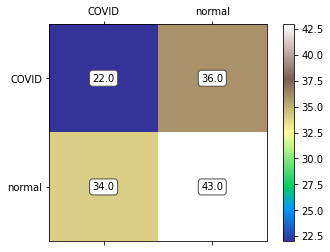

In [ ]:
from sklearn.metrics import confusion_matrix
cmat = confusion_matrix(y_true, y_pred)
fig = plt.figure()
ax = fig.add_subplot(111)
cax = ax.matshow(confusion_matrix(y_true, y_pred), cmap="terrain", interpolation='nearest')
fig.colorbar(cax)

ax.set_xticklabels(['']+class_names, rotation=270)
ax.set_yticklabels(['']+class_names)

for (i, j), z in np.ndenumerate(cmat):
    ax.text(j, i, '{:0.1f}'.format(z), ha='center', va='center',
            bbox=dict(boxstyle='round', facecolor='white', edgecolor='0.3'))

plt.show()

* Recall(sensibilidade) = VP / VP + FN
* Precision(especificidade) = VP / VP + FP


In [ ]:
from sklearn.metrics import classification_report
print(classification_report(y_true, y_pred, target_names=class_names, digits=4))

              precision    recall  f1-score   support

       COVID     0.3929    0.3793    0.3860        58
      normal     0.5443    0.5584    0.5513        77

    accuracy                         0.4815       135
   macro avg     0.4686    0.4689    0.4686       135
weighted avg     0.4792    0.4815    0.4803       135

